In [2]:
%run ./Vlad_Dissertation.ipynb

/home/renato/.virtualenvs/pps/lib/python3.11/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
/tmp/ipykernel_35957/1247435164.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


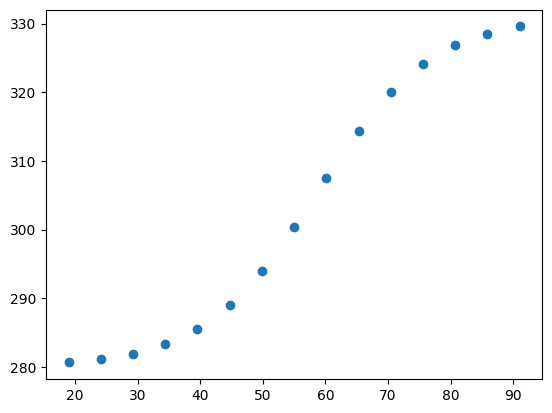

In [4]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
ts = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
mydistances = 100 - ts * v  # distance points in cm (network coordinates)

##Pre-Training
###Healthy Controls
ymin = 280
ymax = 331
fprHCCP = 100 - 1.377 * v
fprHCS = 1 / 0.11  # negative

HC_RTs = RTsig(mydistances, fprHCCP, fprHCS)
plt.scatter(mydistances, HC_RTs)

In [5]:
from scipy.optimize import differential_evolution

HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(1.3, 2, 1.3, 2, 1.3, 2)


def boundaryhcmodelrun(theta):
    HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
        6.5, 6.5, 6.5, 6.55, 6.55, 6.55, theta[0], theta[1], theta[2], theta[3]
    )  # feedforward and feedback
    _, _, _, _, HCrt = experiment(
        0.4,
        200,
        mydistances,
        5,
        HCLt,
        HCLa,
        HCLv,
        HCWt,
        HCWa,
        HCWv,
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        0,
        0,
    )

    xf = HCrt
    yf = HC_RTs

    m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
        xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
    )
    bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

    if bias < 0:
        bias = 0
    if m < 0:
        m = 0

    cost = np.sum(np.square(np.divide(yf - (m * xf + bias), yf)))

    return cost * 100000


bounds = [(1, 50), (500, 1000), (20, 80), (0.25, 1)]  # k1, k2, lim, alpha
boundaryhcres = differential_evolution(
    boundaryhcmodelrun, bounds, disp=True, workers=-1, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 13.561360771658858
differential_evolution step 2: f(x)= 13.561360771658858
differential_evolution step 3: f(x)= 9.253211962802396
differential_evolution step 4: f(x)= 6.641105367132498
differential_evolution step 5: f(x)= 6.641105367132498
differential_evolution step 6: f(x)= 6.641105367132498
differential_evolution step 7: f(x)= 5.764574127259496
differential_evolution step 8: f(x)= 2.4673020362355778
differential_evolution step 9: f(x)= 2.4673020362355778
differential_evolution step 10: f(x)= 2.4673020362355778
differential_evolution step 11: f(x)= 2.4673020362355778
differential_evolution step 12: f(x)= 2.4673020362355778
differential_evolution step 13: f(x)= 2.4673020362355778
differential_evolution step 14: f(x)= 2.4673020362355778
differential_evolution step 15: f(x)= 2.4673020362355778
differential_evolution step 16: f(x)= 2.4673020362355778
differential_evolution step 17: f(x)= 2.4673020362355778
differential_evolution step 18: f(x)= 2.46730

In [7]:
print(boundaryhcres)

             message: Optimization terminated successfully.
             success: True
                 fun: 1.9998535870880996
                   x: [ 1.185e+01  7.769e+02  3.881e+01  9.517e-01]
                 nit: 119
                nfev: 7200
          population: [[ 1.185e+01  7.769e+02  3.881e+01  9.517e-01]
                       [ 1.183e+01  8.239e+02  3.884e+01  9.516e-01]
                       ...
                       [ 1.188e+01  9.115e+02  3.881e+01  9.524e-01]
                       [ 1.178e+01  8.044e+02  3.886e+01  9.509e-01]]
 population_energies: [ 2.000e+00  2.000e+00 ...  2.000e+00  2.000e+00]


In [10]:
## Fitted model

HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(1.3, 2, 1.3, 2, 1.3, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.185e01, 7.769e02, 3.881e01, 9.517e-01
)
_, _, _, _, HC_Model_RTs = experiment(
    0.4,
    200,
    mydistances,
    5,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    0,
)

HC_Model_RTs = fit_RT(HC_Model_RTs, HC_RTs)

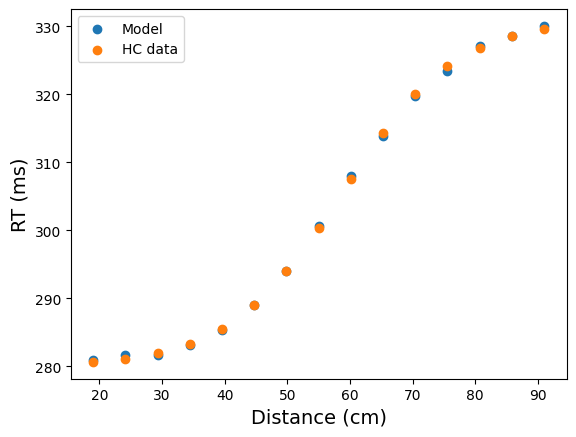

In [11]:
plt.scatter(mydistances, HC_Model_RTs, label="Model")
plt.scatter(mydistances, HC_RTs, label="HC data")
plt.ylabel("RT (ms)", size=14)
plt.xlabel("Distance (cm)", size=14)
plt.legend(prop={"size": 12})
plt.legend()